In [1]:
!conda activate DS807

'conda' is not recognized as an internal or external command,
operable program or batch file.


## Preparation of data

### Labeling Data and converting images to array values

In [2]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [3]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,4123,1825,0,2,5,"[[[153.0], [151.0], [151.0], [151.0], [152.0],...",4123.jpg
1,1063,1826,0,2,6,"[[[161.0], [160.0], [159.0], [159.0], [163.0],...",1063.jpg
2,11529,1825,0,2,5,"[[[148.0], [148.0], [146.0], [144.0], [144.0],...",11529.jpg
3,1781,1819,0,1,9,"[[[141.0], [145.0], [146.0], [144.0], [145.0],...",1781.jpg
4,4270,1801,0,0,1,"[[[135.0], [134.0], [134.0], [136.0], [136.0],...",4270.jpg
...,...,...,...,...,...,...,...
11995,11509,1824,0,2,4,"[[[160.0], [159.0], [165.0], [163.0], [161.0],...",11509.jpg
11996,10999,1818,0,1,8,"[[[133.0], [133.0], [125.0], [130.0], [123.0],...",10999.jpg
11997,7189,1831,0,3,1,"[[[30.0], [29.0], [29.0], [30.0], [30.0], [27....",7189.jpg
11998,2379,1814,0,1,4,"[[[129.0], [124.0], [130.0], [127.0], [125.0],...",2379.jpg


### Defining fixed train, test and valdiation sets.

In [6]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [7]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [8]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [9]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.2.C, Data augmentation in modelling

In [10]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 1))
])
#bright = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.3,0.9])
#data_augmentation.add(bright)

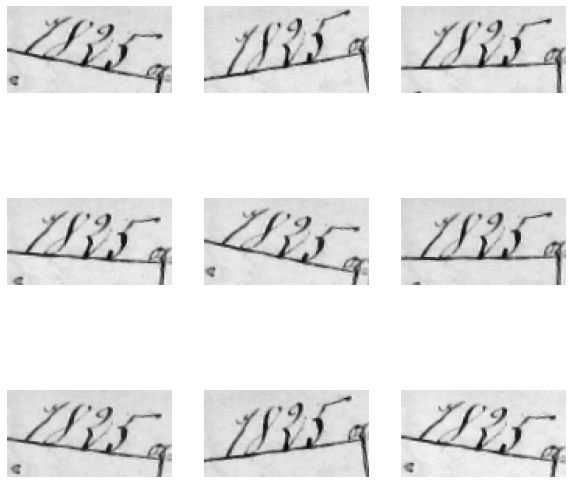

In [12]:
image_aug = x_train.copy()
plt.figure(figsize=(10, 10))
for i in range(9):
    augim = data_augmentation(image_aug, training=True)[0] # Stress training=True
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(augim, cmap = 'gray')

In [13]:
augim.shape

TensorShape([56, 106, 1])

In [22]:
model_da = tf.keras.models.Sequential([
    data_augmentation, # only new part!
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_da.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )


In [23]:
model_da.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 56, 106, 1)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 54, 104, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 52, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 23, 64)       

In [24]:
history_aug = model_da.fit(x_train, 
                        Y_train, 
                        epochs=50,  
                        validation_data=(x_val, Y_val),
                        verbose=1)


MemoryError: Unable to allocate 174. MiB for an array with shape (7680, 56, 106, 1) and data type float32

In [ ]:
#augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10)
#train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
#test_datagen = ImageDataGenerator(rescale=1./255) 